# Imports and Seed Management

In [1]:
from setup import Env

EXPERIMENT_NAME = "exploratory-data-analysis"

env = Env(EXPERIMENT_NAME)

Environment loaded. Project path: /sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification


In [2]:
import os

os.environ['PYTHONHASHSEED'] = str(51)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import wandb
import pandas as pd
import fiftyone as fo
import fiftyone.brain as fob
import glob

from src.datasets import EmbeddingDataset
from src.models import (
    MegaDescriptorL384,
    ArcFaceModel
)
from src.submission import prepare_submission_file
from src.training import train_loop
from src.utils import (
    get_device,
    set_seeds,
    create_stratified_split,
    get_embeddings,
    get_train_df,
    get_identity_counts,
    create_deterministic_training_dataloader,
)
from src.visualization import (
    visualize_train_val_distribution,
    visualize_identity_distribution,
    visualize_embeddings_mds,
    visualize_nearest_neighbors,
    visualize_training_history
)
from src.wandb import (
    log_train_val_distribution,
    add_model_artifact,
    add_submission_artifact
)

# Set random seeds for reproducibility
RANDOM_SEED = 42
set_seeds(RANDOM_SEED)

print(f"PyTorch version: {torch.__version__}")

All random seeds set to 42 for reproducibility
PyTorch version: 2.9.1+cu128


Initialize wandb run.

In [3]:
# Configuration
config = {
    # Model
    "embedding_model": MegaDescriptorL384.get_model_name(),
    "embedding_dim": 256,
    "hidden_dim": 512,
    "batch_size": 32,
    
    # ArcFace
    "arcface_margin": 0.5,
    "arcface_scale": 64.0,
    "dropout": 0.3,

    # Reproducibility
    "seed": RANDOM_SEED,
}

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  embedding_model: hf-hub:BVRA/MegaDescriptor-L-384
  embedding_dim: 256
  hidden_dim: 512
  batch_size: 32
  arcface_margin: 0.5
  arcface_scale: 64.0
  dropout: 0.3
  seed: 42


In [4]:
# Initialize Weights and Biases for experiment tracking
# Key hyperparameters are tracked explicitly for easy filtering in W&B dashboard
wandb.login(key=env.WANDB_API_KEY)

wandb.init(
    project=env.WANDB_PROJECT,
    config=config,
    name=EXPERIMENT_NAME,
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: Appending key for api.wandb.ai to your netrc file: /sc/home/karl.schuetz/.netrc
wandb: Currently logged in as: karl-schuetz (karl-schuetz-hasso-plattner-institut) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Dataset Creation

The existing dataset is removed if it already exists. Please be aware that any additional changes will be lost if the notebook is rerun.

In [5]:
dataset_name = "jaguar-reid-dataset"

# Remove existing dataset if it exists
if dataset_name in fo.list_datasets():
    fo.delete_dataset(dataset_name)

dataset = fo.Dataset(dataset_name)

Load all training images from the train path while using the CSV for the ground thruth label.

In [6]:
train_csv_path = env.DATA_PATH / "train.csv"
train_image_folder_path = env.DATA_PATH / "train"

train_data = pd.read_csv(train_csv_path)
    
train_samples = []
for idx, row in train_data.iterrows():
    img_path = train_image_folder_path / row['filename']
    ground_truth = row['ground_truth']
    
    sample = fo.Sample(
        name=row['filename'],
        filepath=str(img_path),
        ground_truth=fo.Classification(label=ground_truth),
        tags=["train"]
    )
    train_samples.append(sample)

dataset.add_samples(train_samples)
dataset.save()

 100% |███████████████| 1895/1895 [1.2s elapsed, 0s remaining, 1.6K samples/s]         


Load the test data from the test image folder without CSV.

In [7]:
test_image_folder_path = env.DATA_PATH / "test"
test_image_paths = glob.glob(str(test_image_folder_path / "*.png"))

test_samples = []
for img_path in test_image_paths:
    sample = fo.Sample(
        name=img_path.split("/")[-1],
        filepath=img_path,
        ground_truth=fo.Classification(label="unknown"),
        tags=["test"]
    )
    test_samples.append(sample)

dataset.add_samples(test_samples)
dataset.save()

 100% |█████████████████| 371/371 [171.3ms elapsed, 0s remaining, 2.2K samples/s]     


In [8]:
dataset.compute_metadata()

Computing metadata...
  14% |██-------------|  328/2266 [1.4s elapsed, 9.1s remaining, 126.3 samples/s]    

 100% |███████████████| 2266/2266 [4.3s elapsed, 0s remaining, 514.9 samples/s]      


In [9]:
tag_counts = dataset.count_sample_tags()
print(f"Tag counts after split: {tag_counts}")

Tag counts after split: {'test': 371, 'train': 1895}


Class distribution visualization for the training and validation splits.

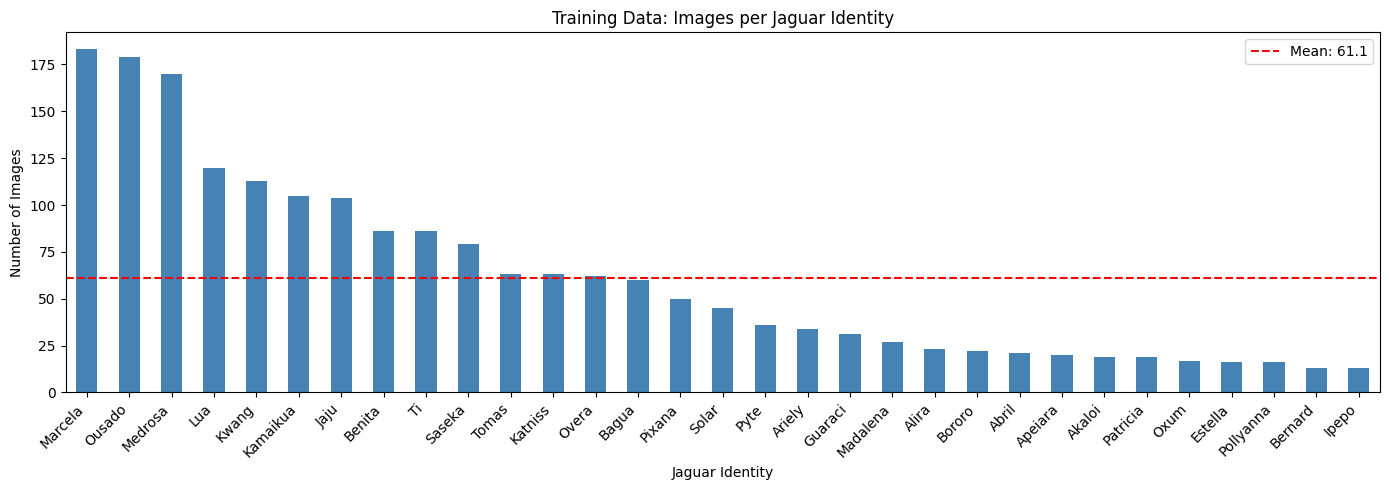

In [10]:
train_view = dataset.match_tags("train")
train_identity_counts = train_view.count_values("ground_truth.label")
train_identity_counts_df = pd.Series(train_identity_counts).sort_values(ascending=False)

num_classes = len(train_identity_counts_df)

fig = visualize_identity_distribution(train_identity_counts_df)

# Embedding Analysis

In [11]:
device = get_device()
print(f"Using device: {device}")

Using CUDA GPU
Using device: cuda


In [12]:
megadescriptor = MegaDescriptorL384()
megadescriptor.to(device)
megadescriptor.print_model_summary()

Model loaded successfully
  Parameters: 195,198,516
  Embedding dimension: 1536


In [13]:
model = ArcFaceModel(
    input_dim=megadescriptor.get_embedding_size(),
    num_classes=num_classes,
    embedding_dim=config["embedding_dim"],
    hidden_dim=config["hidden_dim"],
    margin=config["arcface_margin"],
    dropout=config["dropout"],
).to(device)
model.print_model_summary()


ArcFace Model:
Embedding Projection:
  Input dim: 1536
  Hidden dim: 512
  Output dim: 256
  Dropout: 0.3
  Num classes: 31
  ArcFace margin: 0.5
  ArcFace scale: 64.0
  Total parameters: 927,744


In [14]:
checkpoint_path = env.PROJECT_PATH / "checkpoints" / "megadescriptor-arcface-local" / "arcface_best.pth"
add_model_artifact(checkpoint_path)

checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

model.load_state_dict(checkpoint['model_state_dict'])
_ = model.eval()

Model artifact saved to W&B


In [15]:
preprocess = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [16]:
image_paths = [sample.filepath for sample in dataset]
cache_path = env.EMBEDDINGS_PATH / "embeddings.npz"

megadescriptor_embeddings = get_embeddings(
    model=megadescriptor,
    preprocess=preprocess,
    image_paths=image_paths,
    batch_size=config["batch_size"],
    cache_path=cache_path,
    device=device,
)
megadescriptor_embeddings.shape

Loaded cached embeddings from /sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/checkpoints/exploratory-data-analysis/embeddings/embeddings.npz
Embeddings shape: (2266, 1536)


(2266, 1536)

/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


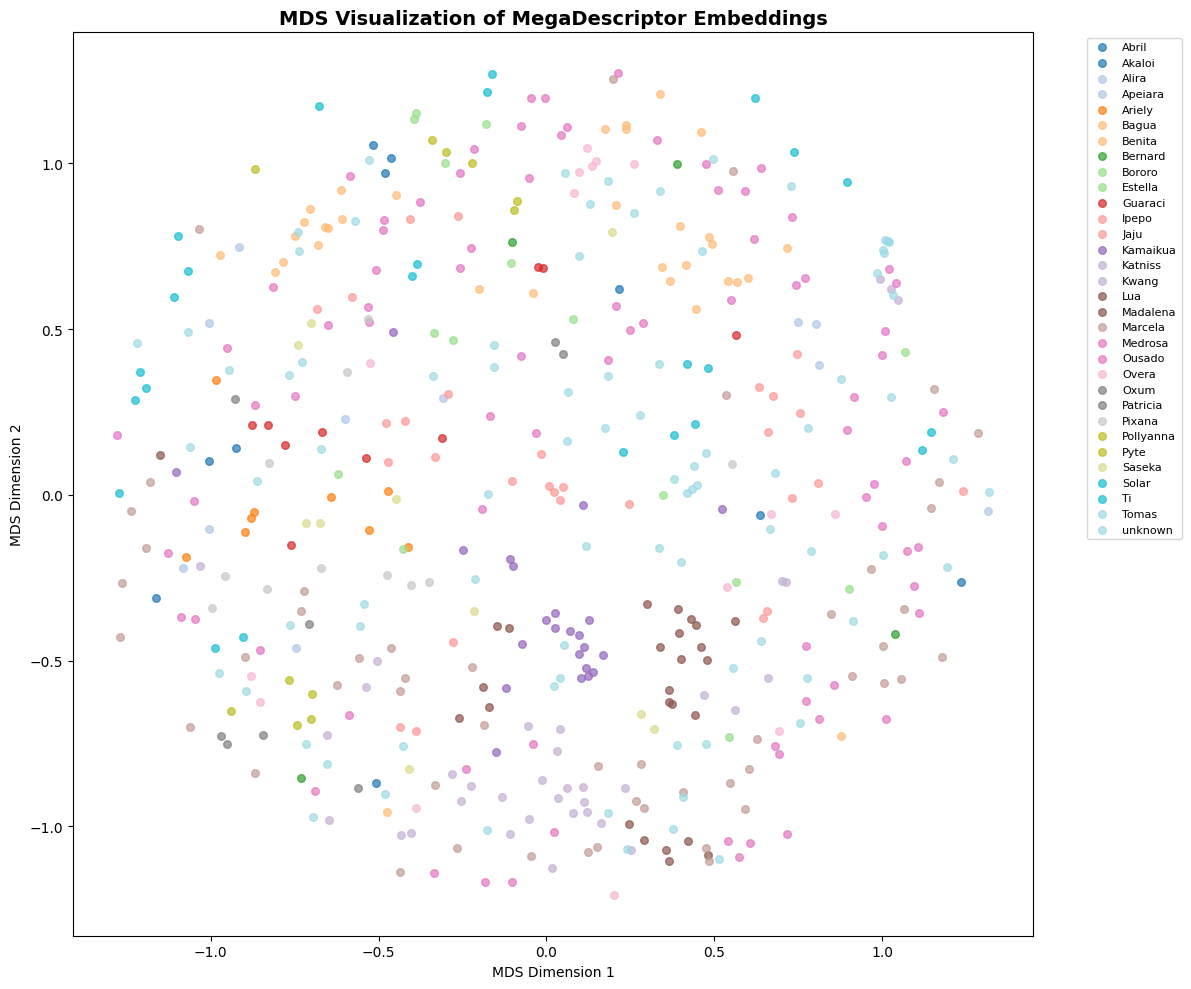

In [17]:
labels = np.array([sample['ground_truth.label'] for sample in dataset])

fig_finetuned = visualize_embeddings_mds(
    megadescriptor_embeddings,
    labels,
    "MDS Visualization of MegaDescriptor Embeddings",
    config["seed"],
    log_name="megadescriptor_embeddings_mds"
)

In [18]:
with torch.no_grad():
    torch_embeddings = torch.from_numpy(megadescriptor_embeddings).to(device)
    arcface_embeddings = model.get_embeddings(torch_embeddings).cpu()

/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


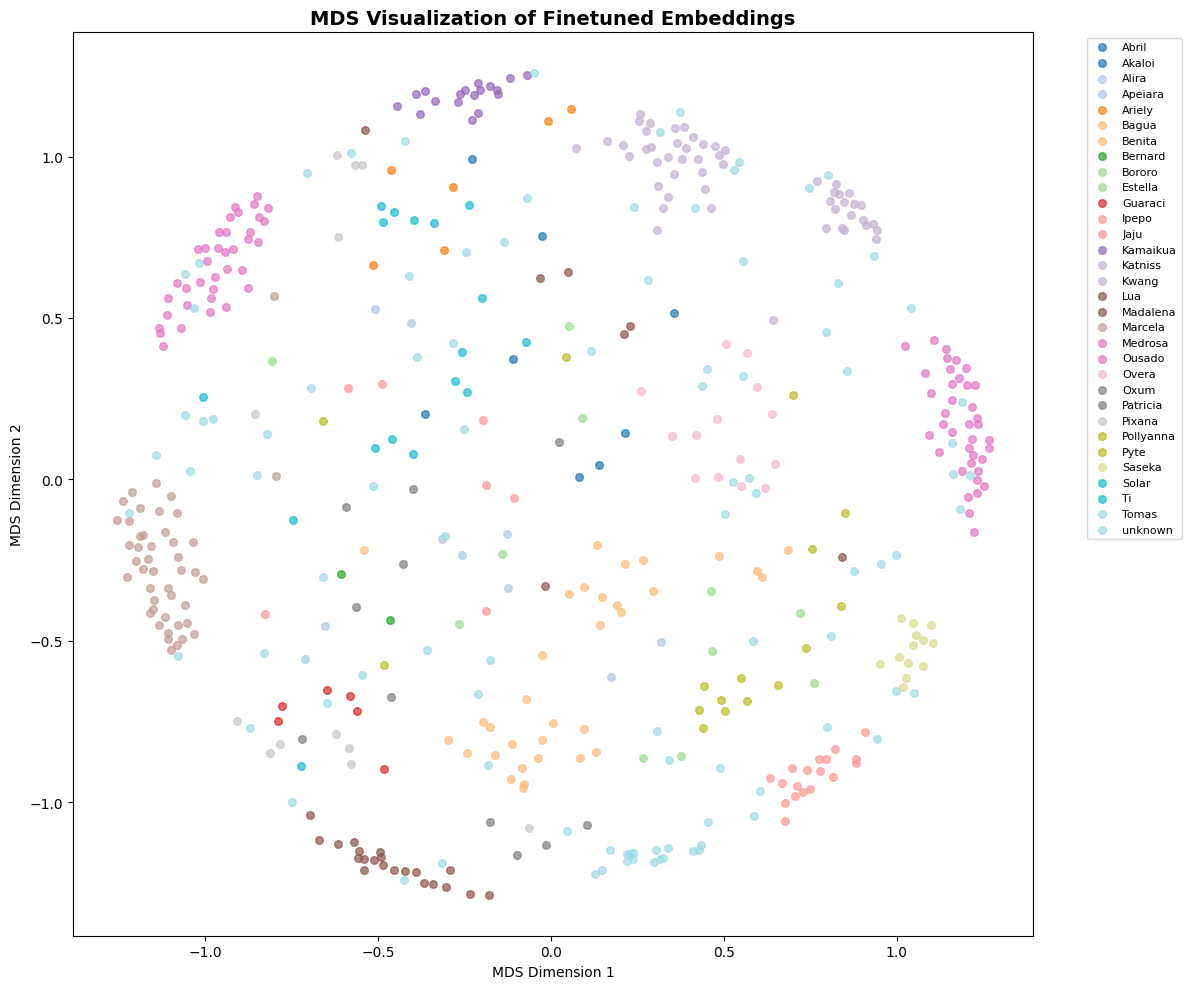

In [19]:
fig_finetuned = visualize_embeddings_mds(
    arcface_embeddings,
    labels,
    "MDS Visualization of Finetuned Embeddings",
    config["seed"],
    log_name="arcface_embeddings_mds"
)

In [20]:
for sample, megadescriptor_embedding, finetuned_embedding in zip(dataset, megadescriptor_embeddings, arcface_embeddings):
    sample["megadescriptor_embedding"] = megadescriptor_embedding.tolist()
    sample["finetuned_embedding"] = finetuned_embedding.cpu().tolist()
    sample.save()

dataset.save()

In [21]:
similarity_index = fob.compute_similarity(
    dataset,
    embeddings="megadescriptor_embedding",
    brain_key="cosine_similarity_index_megadescriptor",
    backend="sklearn",
    metric="cosine"
)

similarity_index = fob.compute_similarity(
    dataset,
    embeddings="finetuned_embedding",
    brain_key="cosine_similarity_index_finetuned",
    backend="sklearn",
    metric="cosine"
)

Generating visualization...
Generating visualization...
UMAP( verbose=True)
Sun Feb  8 12:45:20 2026 Construct fuzzy simplicial set
Sun Feb  8 12:45:26 2026 Finding Nearest Neighbors
Sun Feb  8 12:45:31 2026 Finished Nearest Neighbor Search
Sun Feb  8 12:45:34 2026 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Feb  8 12:45:43 2026 Finished embedding


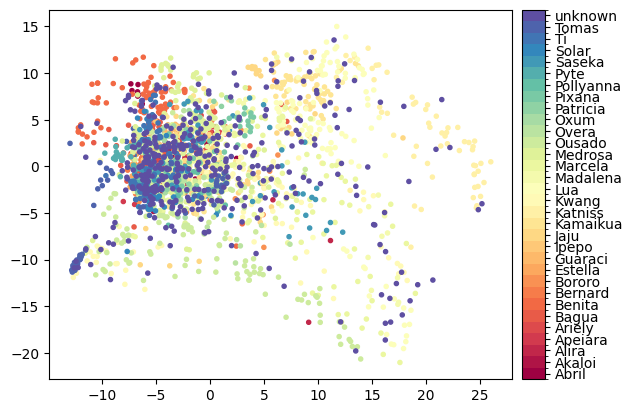

In [ ]:
pca_visualization = fob.compute_visualization(
    dataset,
    method="pca",
    embeddings="megadescriptor_embedding",
    num_dims=2,
    brain_key="pca_visualization_megadescriptor"
)

plot = pca_visualization.visualize(labels="ground_truth.label", backend="matplotlib")
plot.save(env.CHECKPOINT_PATH / "megadescriptor_embeddings_pca.png")
wandb.log({"megadescriptor_embeddings_pca": wandb.Image(env.CHECKPOINT_PATH / "megadescriptor_embeddings_pca.png")})

umap_visualization = fob.compute_visualization(
    dataset,
    method="umap",
    embeddings="megadescriptor_embedding",
    num_dims=2,
    brain_key="umap_visualization_megadescriptor"
)
plot = umap_visualization.visualize(labels="ground_truth.label", backend="matplotlib")
plot.save(env.CHECKPOINT_PATH / "megadescriptor_embeddings_umap.png")
wandb.log({"megadescriptor_embeddings_umap": wandb.Image(env.CHECKPOINT_PATH / "megadescriptor_embeddings_umap.png")})

Generating visualization...
Generating visualization...
UMAP( verbose=True)
Sun Feb  8 12:46:58 2026 Construct fuzzy simplicial set
Sun Feb  8 12:47:03 2026 Finding Nearest Neighbors
Sun Feb  8 12:47:03 2026 Finished Nearest Neighbor Search
Sun Feb  8 12:47:03 2026 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs


	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Feb  8 12:47:06 2026 Finished embedding


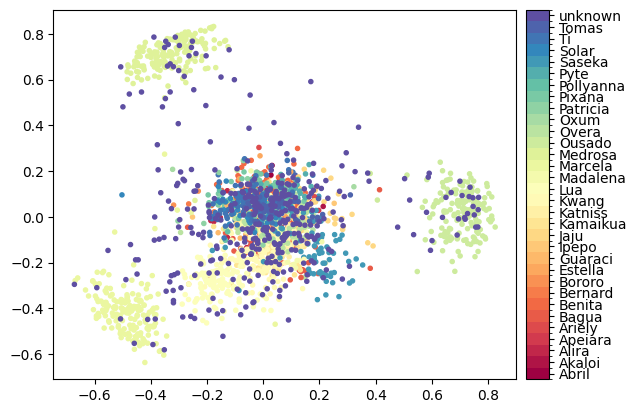

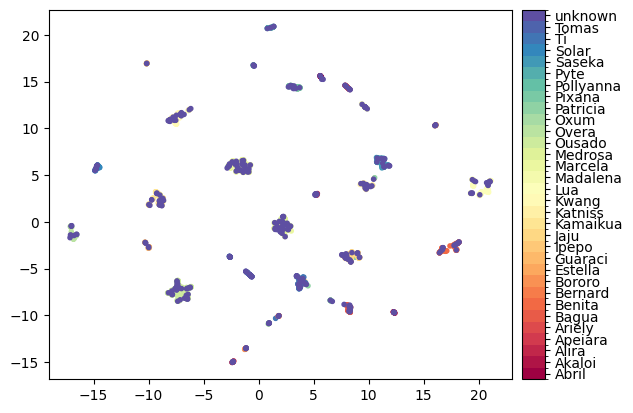

In [31]:
pca_visualization = fob.compute_visualization(
    dataset,
    method="pca",
    embeddings="finetuned_embedding",
    num_dims=2,
    brain_key="pca_visualization_finetuned"
)

plot = pca_visualization.visualize(labels="ground_truth.label", backend="matplotlib")
plot.save(env.CHECKPOINT_PATH / "finetuned_embeddings_pca.png")
wandb.log({"finetuned_embeddings_pca": wandb.Image(env.CHECKPOINT_PATH / "finetuned_embeddings_pca.png")})

umap_visualization = fob.compute_visualization(
    dataset,
    method="umap",
    embeddings="finetuned_embedding",
    num_dims=2,
    brain_key="umap_visualization_finetuned"
)
plot = umap_visualization.visualize(labels="ground_truth.label", backend="matplotlib")
plot.save(env.CHECKPOINT_PATH / "finetuned_embeddings_umap.png")
wandb.log({"finetuned_embeddings_umap": wandb.Image(env.CHECKPOINT_PATH / "finetuned_embeddings_umap.png")})

In [32]:
fob.compute_uniqueness(
    dataset,
    embeddings="finetuned_embedding"
)

fob.compute_representativeness(
    dataset,
    embeddings="finetuned_embedding"
)

Computing uniqueness...
Uniqueness computation complete
Computing representativeness...
Computing clusters for 2266 embeddings; this may take awhile...
Representativeness computation complete


# Session

Launch app for visual inspection.

In [ ]:
session = fo.launch_app(dataset, auto=False)
session.open_tab()


Could not connect session, trying again in 10 seconds

Session launched. Run `session.show()` to open the App in a cell output.

Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.11.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



<IPython.core.display.Javascript object>

In [34]:
session = fo.launch_app(dataset)

# Export

Export the created dataset in FiftyOne format. We do not export the files to save memory.

In [ ]:
export_dir = env.DATA_PATH / dataset_name
export_dir.mkdir(parents=True, exist_ok=True)

print(f"Exporting dataset '{dataset_name}' to: {export_dir}")

dataset.export(
    export_dir=str(export_dir),
    dataset_type=fo.types.FiftyOneDataset,  # preserves groups, modalities, metadata, labels, etc.
    overwrite=True,
    progress=True,
    export_media=False,
)

print("Export finished.")

Exporting dataset 'jaguar-reid-dataset' to: /home/matti/Git/finding-tomas/data/jaguar-reid-dataset
Exporting samples...
 100% |██████████████████| 2266/2266 [102.5ms elapsed, 0s remaining, 22.1K docs/s]    
Export finished.
